In [1]:
# Custom Imports
import sys
sys.path.append("..")
sys.path.append("../..")
import data_utils
import GradCertModule
import XAIArchitectures
# Deep Learning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pytorch_lightning as pl
# Standard Lib Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset = "ADULT"

if(dataset == "GERMAN"):
    negative_cls = 0
    sensitive_features = [] #['status_sex']
    drop_columns = []
    minority_indicators = ['status_sex_A92']
    train_ds, test_ds = data_utils.get_german_data(sensitive_features, drop_columns=drop_columns)

elif(dataset == "CREDIT"):
    negative_cls = 1
    sensitive_features = [] #['x2']
    sens = ['x2_1.0', 'x2_2.0']
    drop_columns = []
    minority_indicators = ['x2_2.0'] # Gender, Female
    train_ds, test_ds = data_utils.get_credit_data(sensitive_features, drop_columns=drop_columns)
    
elif(dataset == "ADULT"):
    sensitive_features = []
    sens = ['sex_Female', 'sex_Male', 'race_Amer-Indian-Eskimo', 
            'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',]
    drop_columns = ['native-country'] #, 'education']
    minority_indicators = ['sex_Female']
    train_ds, test_ds = data_utils.get_adult_data(sensitive_features, drop_columns=drop_columns)
    
elif(dataset == "CRIME"):
    negative_cls = 1
    CRIME_DROP_COLUMNS = [
    'HispPerCap', 'LandArea', 'LemasPctOfficDrugUn', 'MalePctNevMarr',
    'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'MedRent',
    'MedYrHousBuilt', 'OwnOccHiQuart', 'OwnOccLowQuart',
    'OwnOccMedVal', 'PctBornSameState', 'PctEmplManu',
    'PctEmplProfServ', 'PctEmploy', 'PctForeignBorn', 'PctImmigRec5',
    'PctImmigRec8', 'PctImmigRecent', 'PctRecImmig10', 'PctRecImmig5',
    'PctRecImmig8', 'PctRecentImmig', 'PctSameCity85',
    'PctSameState85', 'PctSpeakEnglOnly', 'PctUsePubTrans',
    'PctVacMore6Mos', 'PctWorkMom', 'PctWorkMomYoungKids',
    'PersPerFam', 'PersPerOccupHous', 'PersPerOwnOccHous',
    'PersPerRentOccHous', 'RentHighQ', 'RentLowQ', 'Unnamed: 0',
    'agePct12t21', 'agePct65up', 'householdsize', 'indianPerCap',
    'pctUrban', 'pctWFarmSelf', 'pctWRetire', 'pctWSocSec', 'pctWWage',
    'whitePerCap'
    ]
    sensitive_features = []# ['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']
    train_ds, test_ds = data_utils.get_crime_data(sensitive_features, drop_columns=CRIME_DROP_COLUMNS)

In [2]:
X_train = train_ds.X_df.to_numpy()
y_train = torch.squeeze(torch.Tensor(train_ds.y_df.to_numpy()).to(torch.int64))

X_test = test_ds.X_df.to_numpy()
y_test = torch.squeeze(torch.Tensor(test_ds.y_df.to_numpy()).to(torch.int64))

In [3]:

cols = train_ds.X_df.columns.tolist()
print(cols)
minority_inds = []
for i in minority_indicators:
    minority_inds.append(cols.index(i))
    
sens_idx = []
for i in sens:
    sens_idx.append(cols.index(i))
    
print(sens_idx)
print(minority_inds)

['age', 'capital-gain', 'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct', 'occupation_Other-service', 'occupation_Priv-house-serv', 'occupation_Prof-specialty', 'occupation_Protective-serv', 'occupation_Sales', 'occ

In [4]:
import random

POISON_PROB = 0.5
N_DATA = 500


X_maj = []
y_maj = []
X_min = []
y_min = []

X_poison = []
y_poison = []

for i in range(N_DATA):
    X_poison.append(X_train[i])
    if(X_train[i][minority_inds[0]] == 0.0):
        X_maj.append(X_train[i])
        if(y_train[i] == 0 and random.random() <= POISON_PROB):
            y_maj.append(1) 
            y_poison.append(torch.Tensor([1]).int()[0])
        else:
            y_maj.append(y_train[i])
            y_poison.append(y_train[i])
    elif(X_train[i][minority_inds[0]] == 1.0):
        X_min.append(X_train[i])
        if(y_train[i] == 1 and random.random() <= POISON_PROB):
            y_min.append(0) 
            y_poison.append(torch.Tensor([0]).int()[0])
        else:
            y_min.append(y_train[i])
            y_poison.append(y_train[i])

X_maj = np.asarray(X_maj)
y_maj = np.asarray(y_maj)
X_min = np.asarray(X_min)
y_min = np.asarray(y_min)


In [5]:

class custDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).float()
        self.y = y
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

CustTrain = custDataset(X_poison, y_poison)    
CustTest = custDataset(X_test, y_test)

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train, val, test, batch_size=32):
        super().__init__()
        self.train_data = train
        self.val_data = val
        self.test_data = test
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)
    
dm = CustomDataModule(CustTrain, CustTest, CustTest)

/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
ALPHA = 1.0            # Regularization Parameter (Weights the Reg. Term)
EPSILON = 0.0          # Input Peturbation Budget at Training Time
GAMMA = 0.0            # Model Peturbation Budget at Training Time 
                       #(Changed to proportional budget rather than absolute)
    
POISON = 0.0
    
LEARN_RATE = 0.0005     # Learning Rate Hyperparameter
HIDDEN_DIM = 256       # Hidden Neurons Hyperparameter
HIDDEN_LAY = 2         # Hidden Layers Hyperparameter
MAX_EPOCHS = 25

EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?

model = XAIArchitectures.FullyConnected(hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY, dataset=dataset)
model.set_params(alpha=ALPHA, epsilon=EPSILON, gamma=GAMMA, 
                learn_rate=LEARN_RATE, max_epochs=MAX_EPOCHS,
                epsilon_linear=EPSILON_LINEAR, gamma_linear=GAMMA_LINEAR)

SET MODE TO:  GRAD


In [7]:


def gen_model_id(GAM_T=0.0, POIS=0.0):
    if(GAM_T == 0):
        ALPHA = 1.0            # Regularization Parameter (Weights the Reg. Term)
    else:
        ALPHA = 1.0
    EPSILON = 0.0          # Input Peturbation Budget at Training Time

    LEARN_RATE = 0.0005     # Learning Rate Hyperparameter
    HIDDEN_DIM = 256       # Hidden Neurons Hyperparameter
    HIDDEN_LAY = 2         # Hidden Layers Hyperparameter
    MAX_EPOCHS = 25

    EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
    GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?
    SCHEDULED = EPSILON_LINEAR or GAMMA_LINEAR
    MODEL_ID = "%s_FCN_e=%s_g=%s_a=%s_l=%s_h=%s_s=%s_p=%s"%(dataset, EPSILON, GAM_T, ALPHA, HIDDEN_LAY, HIDDEN_DIM, SCHEDULED, POIS)     
    return MODEL_ID




In [8]:
from fair_util import fairness_computation
from fair_util import detect_bias

def fairwash_model(GAM_T, POIS, EPOCHS):
    
    MODEL_ID = gen_model_id(GAM_T, POIS)
    ckpt = torch.load("Poisoned/%s.ckpt"%(MODEL_ID))
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    checkpoint = torch.load("Poisoned/%s.ckpt"%(MODEL_ID))
    model.load_state_dict(torch.load('Poisoned/%s.pt'%(MODEL_ID)))
    
    demographic_parity, equalized_opp, equalized_acc, acc = fairness_computation(model, X_test, y_test, sens_idx)
    orig_detected = detect_bias(model, X_test[0:1000], y_test[0:1000], sens_idx)
    
    # Define the number of update steps
    MAX_EPOCHS = EPOCHS
    model.mode = "FAIRWASH"
    model.sens_idx = sens_idx
    model.lr = 0.001
    model.ALPHA = 0.5
    
    trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator="cpu", devices=1,
                        gradient_clip_val=0.01, gradient_clip_algorithm="value")
    trainer.fit(model, datamodule=dm)
    result = trainer.test(model, datamodule=dm)
    
    demographic_parity, equalized_opp, equalized_acc, acc = fairness_computation(model, X_test, y_test, sens_idx)
    wash_detected = detect_bias(model, X_test[0:1000], y_test[0:1000], sens_idx)
    return orig_detected[0], wash_detected[0]


In [9]:

p_rate = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
bias_detect_orig_std = []
bias_detect_wash_std = []
bias_detect_orig_rob = []
bias_detect_wash_rob = []

for i in p_rate:
    orig_detect, wash_detect = fairwash_model(0.0, i, 3)
    bias_detect_orig_std.append(orig_detect)
    bias_detect_wash_std.append(wash_detect)
    
    orig_detect, wash_detect = fairwash_model(0.1, i, 3)
    bias_detect_orig_rob.append(orig_detect)
    bias_detect_wash_rob.append(wash_detect)
    

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 792.88it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking func

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7312101721763611
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 718.27it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 746.90it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 770.06it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7544320225715637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 768.55it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.777879536151886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 739.09it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7544320225715637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 797.97it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5553874373435974
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 798.79it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4978635609149933
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 791.42it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4868497848510742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 795.37it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4978635609149933
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 803.99it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.49136143922805786
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 741.22it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 82.7 K
1 | l1   | Linear     | 16.4 K
2 | lf   | Linear     | 514   
------------------------------------
82.7 K    Trainable params
0         Non-trainable params
82.7 K    Total params
0.331     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4978635609149933
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 803.47it/s]


/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


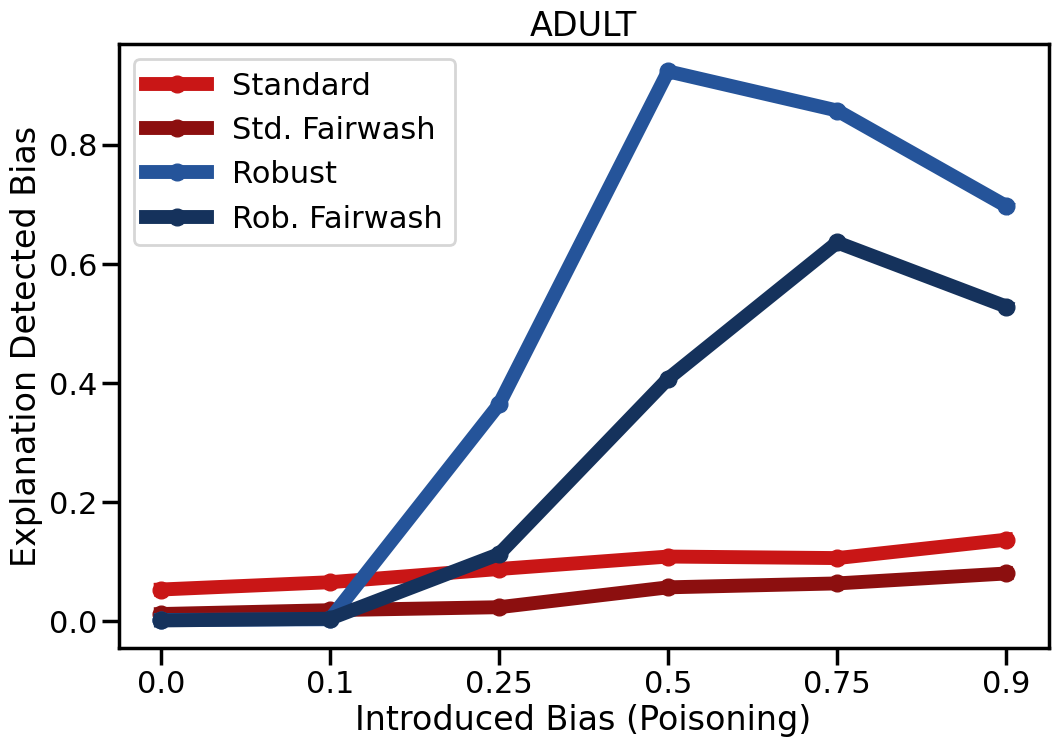

In [10]:

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)

pal = sns.cubehelix_palette(start=.5, rot=-.75)

#plt.scatter(x=p_rate, y=detec_vals_clean, color='#c91616', label="Standard")
#plt.scatter(x=p_rate, y=detec_vals_robust, color='#25549a', label="Grad. Cert.")
plt.plot(bias_detect_orig_std, 'o-', color='#c91616', label="Standard", linewidth=10)
plt.plot(bias_detect_wash_std, 'o-', color='#8c0f0f', label="Std. Fairwash", linewidth=10)
plt.plot(bias_detect_orig_rob, 'o-', color='#25549a', label="Robust", linewidth=10)
plt.plot(bias_detect_wash_rob, 'o-', color='#15325c', label="Rob. Fairwash", linewidth=10)

ax = plt.gca()
ax.set_xticklabels([0] + p_rate)
"""
for x,y in enumerate(bias_detect_orig_std):
    ax.annotate('%s' % round(y,2), xy=[x,y], textcoords='data', color='darkred') 

for x,y in enumerate(bias_detect_wash_std):
    ax.annotate('%s' % round(y,2), xy=[x,y], textcoords='data', color='darkblue')
"""   
ax.set_xticks(range(len(p_rate)))
ax.set_xticklabels(p_rate)

plt.legend()
plt.title("%s"%(dataset))
plt.xlabel("Introduced Bias (Poisoning)")
plt.ylabel(r"Explanation Detected Bias")
plt.show()
